# Data Loading & Preprocessing

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load preprocessed data
X_train_processed = pd.read_csv('/content/drive/MyDrive/Train_Encoded.csv')
X_test_processed = pd.read_csv('/content/drive/MyDrive/Test_Encoded.csv')

In [5]:
#Convert string to list format
X_train_processed['document_vector'] = X_train_processed['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))
X_test_processed['document_vector'] = X_test_processed['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))

In [6]:
# Separate features and class labels
X_train = X_train_processed['document_vector'].tolist()
X_test = X_test_processed['document_vector'].tolist()
y_train = X_train_processed['hate_speech']
y_test = X_test_processed['hate_speech']

In [7]:
class_distribution = y_train.value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
hate_speech
0    13513
1     4229
Name: count, dtype: int64


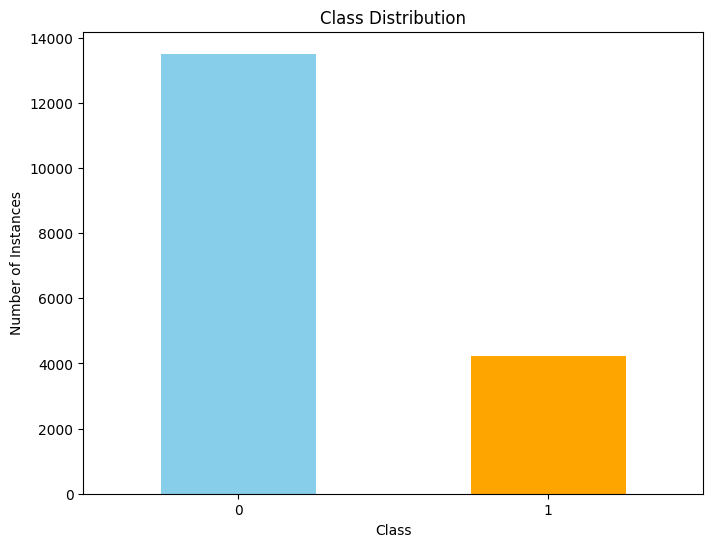

In [8]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
X_train_resampled = np.array(X_train_resampled)

# Check the shape of the resampled dataset
print(X_train_resampled.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_train_resampled.shape)  # Expected shape: (num_samples,)

(27026, 300)
(27026,)


In [11]:
# Reshape train data to match Conv1D input shape: (num_samples, embedding_dim, 1)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
print(X_train_resampled.shape) # Should be (num_samples, embedding_dim, 1)

(27026, 300, 1)


In [12]:
X_test = np.array(X_test)

# Check the shape of the resampled dataset
print(X_test.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_test.shape)  # Expected shape: (num_samples,)

(4436, 300)
(4436,)


In [13]:
# Reshape test data to match Conv1D input shape: (num_samples, embedding_dim, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)  # Should be (num_samples, embedding_dim, 1)

(4436, 300, 1)


# Convolutional Neural Network

## One Conv1D Layer and Filters=256

In [14]:
# Define the CNN model
model1 = Sequential()

# Add a Conv1D layer
model1.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model1.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 256)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 37888)             0         
                                                                 
 dense (Dense)               (None, 1)                 37889     
                                                                 
Total params: 39425 (154.00 KB)
Trainable params: 39425 (154.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Train the model
model1.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 6ms/step - loss: 0.5098 - accuracy: 0.7498 - val_loss: 0.5103 - val_accuracy: 0.7506
Epoch 2/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4158 - accuracy: 0.8219 - val_loss: 0.4732 - val_accuracy: 0.7782
Epoch 3/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3889 - accuracy: 0.8398 - val_loss: 0.3899 - val_accuracy: 0.8487
Epoch 4/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3826 - accuracy: 0.8413 - val_loss: 0.2486 - val_accuracy: 0.9349
Epoch 5/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3677 - accuracy: 0.8502 - val_loss: 0.3846 - val_accuracy: 0.8376
Epoch 6/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3601 - accuracy: 0.8519 - val_loss: 0.3357 - val_accuracy: 0.8774
Epoch 7/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3587 - accuracy: 0.8511 - val_loss: 0.4273 - val_accuracy: 0.8041
Epoch 

In [16]:
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


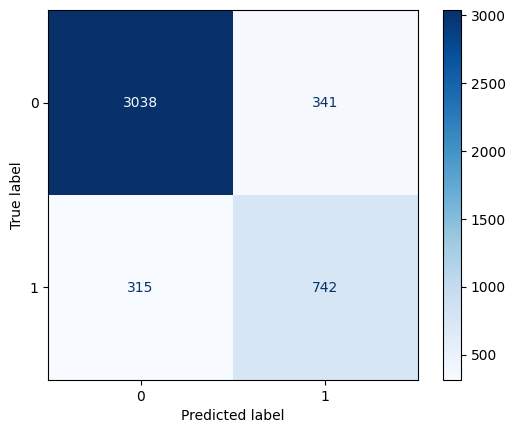

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8521
Precision: 0.6851
Recall: 0.7020
F1 Score: 0.6935


## One Conv1D Layer and Filters=128

In [19]:
# Define the CNN model
model2 = Sequential()

# Add a Conv1D layer
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model2.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model2.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 296, 128)          768       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 148, 128)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18944)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 18945     
                                                                 
Total params: 19713 (77.00 KB)
Trainable params: 19713 (77.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train the model
model2.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 6s 13ms/step - loss: 0.5264 - accuracy: 0.7315 - val_loss: 0.7017 - val_accuracy: 0.5424
Epoch 2/20
338/338 [==============================] - 3s 9ms/step - loss: 0.4257 - accuracy: 0.8135 - val_loss: 0.7084 - val_accuracy: 0.5609
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3971 - accuracy: 0.8379 - val_loss: 0.3428 - val_accuracy: 0.8864
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3872 - accuracy: 0.8383 - val_loss: 0.6318 - val_accuracy: 0.6419
Epoch 5/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3730 - accuracy: 0.8466 - val_loss: 0.5608 - val_accuracy: 0.7033
Epoch 6/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3703 - accuracy: 0.8459 - val_loss: 0.4200 - val_accuracy: 0.8084
Epoch 7/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3642 - accuracy: 0.8530 - val_loss: 0.3991 - val_accuracy: 0.8337
Epoch

In [21]:
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


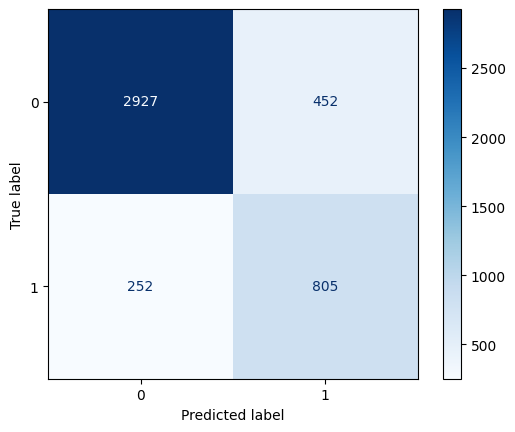

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8413
Precision: 0.6404
Recall: 0.7616
F1 Score: 0.6958


## One Conv1D Layer and Filters=64

In [24]:
# Define the CNN model
model3 = Sequential()

# Add a Conv1D layer
model3.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model3.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model3.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 296, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 148, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9472)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9473      
                                                                 
Total params: 9857 (38.50 KB)
Trainable params: 9857 (38.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Train the model
model3.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 3s 5ms/step - loss: 0.5530 - accuracy: 0.7086 - val_loss: 0.6219 - val_accuracy: 0.6117
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4488 - accuracy: 0.7981 - val_loss: 0.4327 - val_accuracy: 0.8257
Epoch 3/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4131 - accuracy: 0.8237 - val_loss: 0.5219 - val_accuracy: 0.7248
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3961 - accuracy: 0.8340 - val_loss: 0.3411 - val_accuracy: 0.8984
Epoch 5/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3849 - accuracy: 0.8429 - val_loss: 0.4257 - val_accuracy: 0.8110
Epoch 6/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3761 - accuracy: 0.8478 - val_loss: 0.4119 - val_accuracy: 0.8293
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3716 - accuracy: 0.8490 - val_loss: 0.4964 - val_accuracy: 0.7540
Epoch 

In [26]:
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


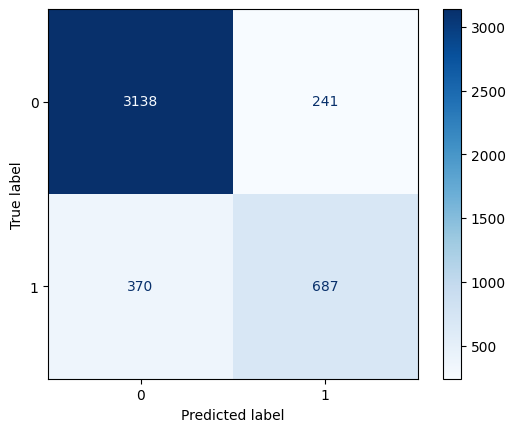

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [28]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8623
Precision: 0.7403
Recall: 0.6500
F1 Score: 0.6922


## One Conv1D Layer and Filters=32

In [29]:
# Define the CNN model
model4 = Sequential()

# Add a Conv1D layer
model4.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model4.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model4.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 296, 32)           192       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 148, 32)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 4736)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4737      
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# Train the model
model4.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 3s 5ms/step - loss: 0.5774 - accuracy: 0.6879 - val_loss: 0.6819 - val_accuracy: 0.5024
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4746 - accuracy: 0.7799 - val_loss: 0.6385 - val_accuracy: 0.6040
Epoch 3/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4368 - accuracy: 0.8067 - val_loss: 0.5043 - val_accuracy: 0.7475
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4114 - accuracy: 0.8271 - val_loss: 0.4665 - val_accuracy: 0.7873
Epoch 5/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3984 - accuracy: 0.8352 - val_loss: 0.5908 - val_accuracy: 0.6676
Epoch 6/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3890 - accuracy: 0.8402 - val_loss: 0.4934 - val_accuracy: 0.7543
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3832 - accuracy: 0.8419 - val_loss: 0.3973 - val_accuracy: 0.8418
Epoch 

In [31]:
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


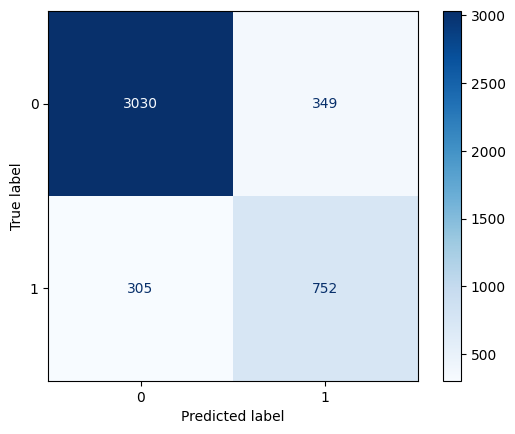

In [32]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [33]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8526
Precision: 0.6830
Recall: 0.7114
F1 Score: 0.6969


## Two Conv1D Layer, Filters= 64 & 32,  Kernal Size= 5 and Pool Size=3

In [34]:
# Define the CNN model
model5 = Sequential()

# Add a Conv1D layer
model5.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model5.add(MaxPooling1D(pool_size=2))

# Add a Conv1D layer
model5.add(Conv1D(filters=32, kernel_size=5, activation='relu'))

# Add a MaxPooling layer
model5.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model5.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 296, 64)           384       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 148, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 144, 32)           10272     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 72, 32)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [35]:
# Train the model
model5.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 8ms/step - loss: 0.5627 - accuracy: 0.7066 - val_loss: 0.4922 - val_accuracy: 0.7738
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4554 - accuracy: 0.7957 - val_loss: 0.4644 - val_accuracy: 0.8108
Epoch 3/20
338/338 [==============================] - 2s 4ms/step - loss: 0.4268 - accuracy: 0.8141 - val_loss: 0.6954 - val_accuracy: 0.6030
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4075 - accuracy: 0.8263 - val_loss: 0.5319 - val_accuracy: 0.7268
Epoch 5/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3932 - accuracy: 0.8344 - val_loss: 0.4760 - val_accuracy: 0.7623
Epoch 6/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3799 - accuracy: 0.8407 - val_loss: 0.3725 - val_accuracy: 0.8489
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3703 - accuracy: 0.8452 - val_loss: 0.3842 - val_accuracy: 0.8420
Epoch 

In [36]:
y_pred = (model5.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


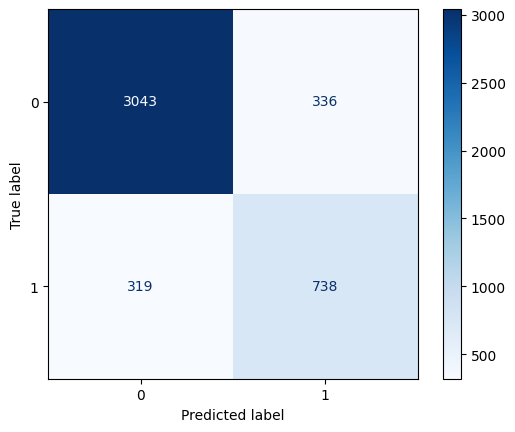

In [37]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8523
Precision: 0.6872
Recall: 0.6982
F1 Score: 0.6926


## Two Conv1D Layer, Filters= 256 & 64,  Kernal Size= 5 and Pool Size=2

In [39]:
# Define the CNN model
model6 = Sequential()

# Add a Conv1D layer
model6.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model6.add(MaxPooling1D(pool_size=2))

# Add a Conv1D layer
model6.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Add a MaxPooling layer
model6.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model6.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 296, 256)          1536      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 148, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 144, 64)           81984     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 72, 64)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [40]:
# Train the model
model6.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 8ms/step - loss: 0.5427 - accuracy: 0.7263 - val_loss: 0.6038 - val_accuracy: 0.6626
Epoch 2/20
338/338 [==============================] - 3s 9ms/step - loss: 0.4285 - accuracy: 0.8157 - val_loss: 0.2978 - val_accuracy: 0.9171
Epoch 3/20
338/338 [==============================] - 3s 8ms/step - loss: 0.3955 - accuracy: 0.8342 - val_loss: 0.4644 - val_accuracy: 0.7878
Epoch 4/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3795 - accuracy: 0.8408 - val_loss: 0.3373 - val_accuracy: 0.8809
Epoch 5/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3627 - accuracy: 0.8493 - val_loss: 0.4130 - val_accuracy: 0.8065
Epoch 6/20
338/338 [==============================] - 3s 8ms/step - loss: 0.3524 - accuracy: 0.8546 - val_loss: 0.5096 - val_accuracy: 0.7447
Epoch 7/20
338/338 [==============================] - 3s 9ms/step - loss: 0.3441 - accuracy: 0.8568 - val_loss: 0.3941 - val_accuracy: 0.8189
Epoch 

In [41]:
y_pred = (model6.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


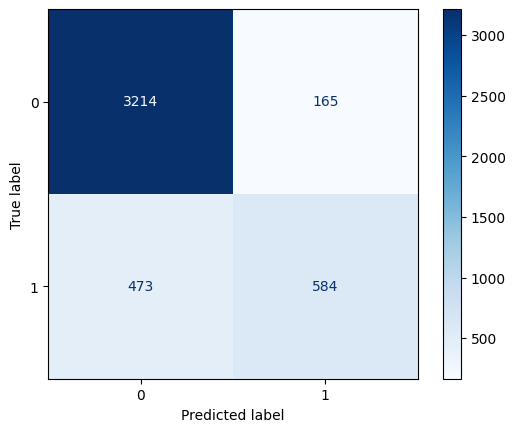

In [42]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8562
Precision: 0.7797
Recall: 0.5525
F1 Score: 0.6467


## Two Conv1D Layer, Filters= 64,  Kernal Size= 5 and Pool Size=2

In [44]:
# Define the CNN model
model7 = Sequential()

# Add a Conv1D layer
model7.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model7.add(MaxPooling1D(pool_size=2))

# Add a Conv1D layer
model7.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Add a MaxPooling layer
model7.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model7.add(Flatten())

# Add the output layer with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 296, 64)           384       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 148, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 144, 64)           20544     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 72, 64)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [45]:
# Train the model
model7.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 6ms/step - loss: 0.5616 - accuracy: 0.7067 - val_loss: 0.7466 - val_accuracy: 0.5211
Epoch 2/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4555 - accuracy: 0.7955 - val_loss: 0.5319 - val_accuracy: 0.7362
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4223 - accuracy: 0.8172 - val_loss: 0.6031 - val_accuracy: 0.6707
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3990 - accuracy: 0.8314 - val_loss: 0.3647 - val_accuracy: 0.8605
Epoch 5/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3855 - accuracy: 0.8389 - val_loss: 0.4243 - val_accuracy: 0.8178
Epoch 6/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3671 - accuracy: 0.8500 - val_loss: 0.5961 - val_accuracy: 0.6828
Epoch 7/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3594 - accuracy: 0.8507 - val_loss: 0.3144 - val_accuracy: 0.8864
Epoch 

In [46]:
y_pred = (model7.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


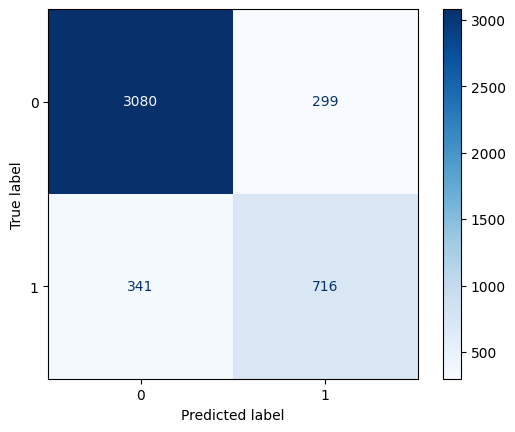

In [47]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8557
Precision: 0.7054
Recall: 0.6774
F1 Score: 0.6911


One layer is better than two layers

## Add Additional Dense Layer: Neurons 32

In [49]:
# Define the CNN model
model8 = Sequential()

# Add a Conv1D layer
model8.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model8.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model8.add(Flatten())

# Add a Dense layer
model8.add(Dense(32, activation='relu'))

# Add the output layer with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 296, 64)           384       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 148, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 9472)              0         
                                                                 
 dense_7 (Dense)             (None, 32)                303136    
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 303553 (1.16 MB)
Trainable params: 303553 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [50]:
# Train the model
model8.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 3s 5ms/step - loss: 0.5324 - accuracy: 0.7389 - val_loss: 0.6676 - val_accuracy: 0.8394
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.4571 - accuracy: 0.8105 - val_loss: 0.6868 - val_accuracy: 0.7399
Epoch 3/20
338/338 [==============================] - 2s 4ms/step - loss: 0.4178 - accuracy: 0.8333 - val_loss: 0.5253 - val_accuracy: 0.8809
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3974 - accuracy: 0.8424 - val_loss: 0.6173 - val_accuracy: 0.7542
Epoch 5/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3777 - accuracy: 0.8530 - val_loss: 0.4379 - val_accuracy: 0.9057
Epoch 6/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3654 - accuracy: 0.8547 - val_loss: 0.3820 - val_accuracy: 0.9279
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3520 - accuracy: 0.8603 - val_loss: 0.5046 - val_accuracy: 0.8128
Epoch 

In [51]:
y_pred = (model8.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


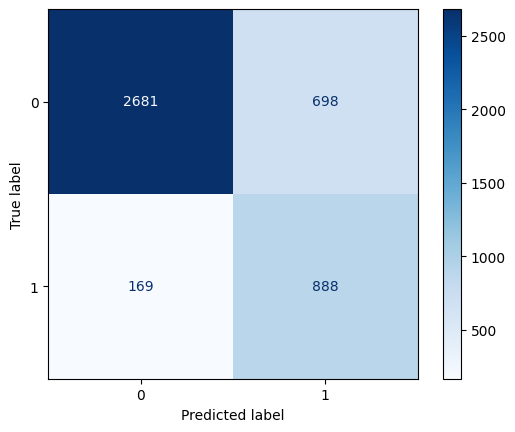

In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [53]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8046
Precision: 0.5599
Recall: 0.8401
F1 Score: 0.6720


## Add Additional Dense Layer: Neurons 64

In [54]:
# Define the CNN model
model9 = Sequential()

# Add a Conv1D layer
model9.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model9.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model9.add(Flatten())

# Add a Dense layer
model9.add(Dense(64, activation='relu'))

# Add the output layer with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 296, 64)           384       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 148, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 9472)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                606272    
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 606721 (2.31 MB)
Trainable params: 606721 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [55]:
# Train the model
model9.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 3s 5ms/step - loss: 0.4818 - accuracy: 0.7697 - val_loss: 0.4191 - val_accuracy: 0.8485
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3938 - accuracy: 0.8308 - val_loss: 0.2669 - val_accuracy: 0.9382
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3708 - accuracy: 0.8408 - val_loss: 0.3104 - val_accuracy: 0.9169
Epoch 4/20
338/338 [==============================] - 3s 8ms/step - loss: 0.3578 - accuracy: 0.8484 - val_loss: 0.3587 - val_accuracy: 0.8470
Epoch 5/20
338/338 [==============================] - 3s 10ms/step - loss: 0.3432 - accuracy: 0.8586 - val_loss: 0.5088 - val_accuracy: 0.7531
Epoch 6/20
338/338 [==============================] - 3s 8ms/step - loss: 0.3385 - accuracy: 0.8590 - val_loss: 0.1664 - val_accuracy: 0.9669
Epoch 7/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3359 - accuracy: 0.8607 - val_loss: 0.3055 - val_accuracy: 0.9020
Epoch

In [56]:
y_pred = (model9.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


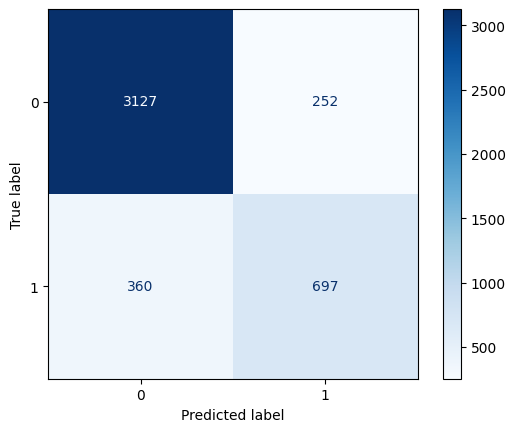

In [57]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [58]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8620
Precision: 0.7345
Recall: 0.6594
F1 Score: 0.6949


## Add Dropout with 20%

In [65]:
# Define the CNN model
model13 = Sequential()

# Add a Conv1D layer
model13.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model13.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model13.add(Flatten())

# Add a Dense layer
model13.add(Dense(64, activation='relu'))

model13.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model13.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 296, 64)           384       
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 148, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 9472)              0         
                                                                 
 dense_13 (Dense)            (None, 64)                606272    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                     

In [66]:
# Train the model
model13.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 5ms/step - loss: 0.4870 - accuracy: 0.7636 - val_loss: 0.4143 - val_accuracy: 0.8674
Epoch 2/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3973 - accuracy: 0.8285 - val_loss: 0.4735 - val_accuracy: 0.7932
Epoch 3/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3770 - accuracy: 0.8396 - val_loss: 0.4325 - val_accuracy: 0.8420
Epoch 4/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3633 - accuracy: 0.8486 - val_loss: 0.3279 - val_accuracy: 0.9020
Epoch 5/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3551 - accuracy: 0.8494 - val_loss: 0.3387 - val_accuracy: 0.8922
Epoch 6/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3515 - accuracy: 0.8504 - val_loss: 0.3733 - val_accuracy: 0.8533
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3403 - accuracy: 0.8567 - val_loss: 0.3084 - val_accuracy: 0.8916
Epoch 

In [67]:
y_pred = (model13.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


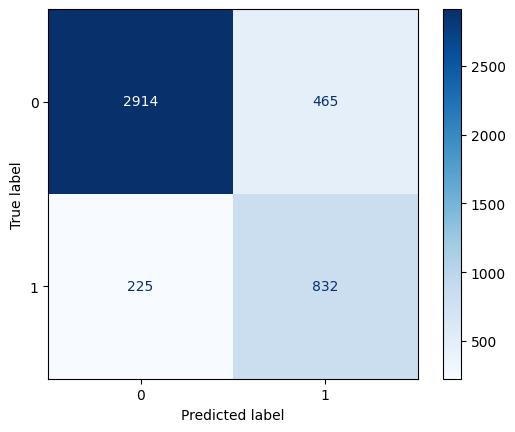

In [68]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [69]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8445
Precision: 0.6415
Recall: 0.7871
F1 Score: 0.7069


## Add Dropout with 50%

In [70]:
# Define the CNN model
model14 = Sequential()

# Add a Conv1D layer
model14.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model14.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model14.add(Flatten())

# Add a Dense layer
model14.add(Dense(64, activation='relu'))

model14.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model14.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 296, 64)           384       
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 148, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 9472)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                606272    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                     

In [71]:
# Train the model
model14.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 3s 6ms/step - loss: 0.5123 - accuracy: 0.7441 - val_loss: 0.5565 - val_accuracy: 0.7540
Epoch 2/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4328 - accuracy: 0.8056 - val_loss: 0.5025 - val_accuracy: 0.7810
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4022 - accuracy: 0.8254 - val_loss: 0.5241 - val_accuracy: 0.7566
Epoch 4/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3897 - accuracy: 0.8333 - val_loss: 0.3575 - val_accuracy: 0.8709
Epoch 5/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3792 - accuracy: 0.8396 - val_loss: 0.4815 - val_accuracy: 0.7721
Epoch 6/20
338/338 [==============================] - 2s 5ms/step - loss: 0.3733 - accuracy: 0.8429 - val_loss: 0.4336 - val_accuracy: 0.8232
Epoch 7/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3720 - accuracy: 0.8456 - val_loss: 0.3864 - val_accuracy: 0.8444
Epoch 

In [72]:
y_pred = (model14.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


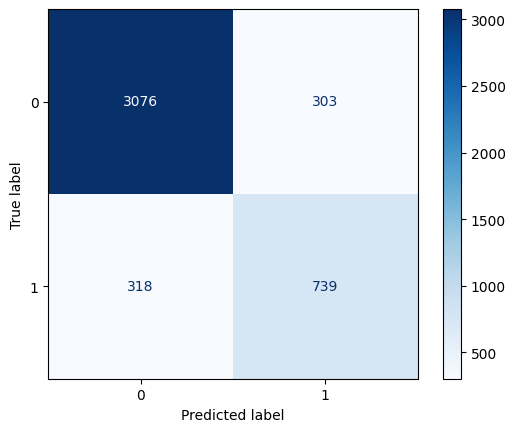

In [73]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [74]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8600
Precision: 0.7092
Recall: 0.6991
F1 Score: 0.7041


# Model Tuning

### Implement early stopping and learning rate reduction techniques, while ensuring that 'y_pred' achieves a balanced precision and recall.


In [81]:
# Define the CNN model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 296, 64)           384       
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 148, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 9472)              0         
                                                                 
 dense_19 (Dense)            (None, 64)                606272    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                     

In [82]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [91]:
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=64)

Epoch 1/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3218 - accuracy: 0.8729 - val_loss: 0.3692 - val_accuracy: 0.8659
Epoch 2/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3258 - accuracy: 0.8718 - val_loss: 0.3241 - val_accuracy: 0.9010
Epoch 3/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3219 - accuracy: 0.8719 - val_loss: 0.3412 - val_accuracy: 0.8864
Epoch 4/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3194 - accuracy: 0.8729 - val_loss: 0.3421 - val_accuracy: 0.8875
Epoch 5/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3198 - accuracy: 0.8729 - val_loss: 0.3002 - val_accuracy: 0.9149
Epoch 6/20
338/338 [==============================] - 1s 4ms/step - loss: 0.3170 - accuracy: 0.8760 - val_loss: 0.3330 - val_accuracy: 0.8944
Epoch 7/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3180 - accuracy: 0.8740 - val_loss: 0.3851 - val_accuracy: 0.8496
Epoch 

In [92]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


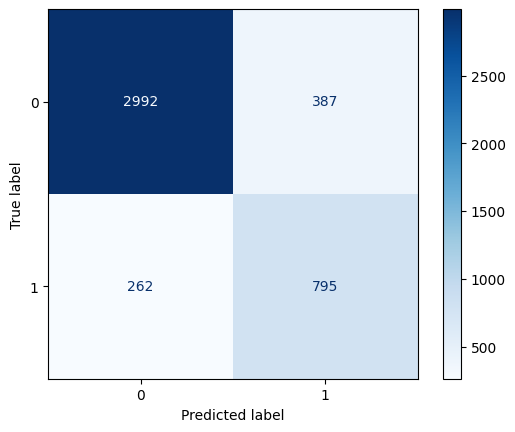

In [93]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [94]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8537
Precision: 0.6726
Recall: 0.7521
F1 Score: 0.7101
